In [1]:
# import libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score

%matplotlib inline

# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('C:/Users/TienTTT13/Downloads/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('C:/Users/TienTTT13/Downloads/Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\TienTTT13\AppData\Local\Temp\ipykernel_25172\565152390.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('C:/Users/TienTTT13/Downloads/Udacity_AZDIAS_052018.csv', sep=';')
C:\Users\TienTTT13\AppData\Local\Temp\ipykernel_25172\565152390.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('C:/Users/TienTTT13/Downloads/Udacity_CUSTOMERS_052018.csv', sep=';')


### Data exploration and Understanding

In [3]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
azdias.shape

(891221, 366)

In [5]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [6]:
customers.shape

(191652, 369)

In [7]:
list(set(customers.columns) - set(azdias.columns))

['CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE']

In [8]:
customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis = 1, inplace = True)

In [9]:
customers.shape

(191652, 366)

Cleaning column-wise missing data

In [10]:
#To figure out a threshold for dropping columns, we can plot number 
#of columns at different percentage of missing values
def plot_missing_value_histogram_col(df):
    """
    Plot histogram of missing values to find a threshold for dropping columns.
    
    Parameters:
    df (DataFrame): Input DataFrame
    
    Returns:
    None
    """
    # Calculate the percentage of missing values for each column and sort them
    missing_percent = df.isnull().mean() * 100
    missing_percent_sorted = missing_percent.sort_values(ascending=False)
    
    # Create a DataFrame for the missing values
    missing_percent_df = pd.DataFrame({
        'column_name': missing_percent_sorted.index,
        'percent_missing': missing_percent_sorted.values
    })
    
    # Plot histogram
    missing_percent_df.head(50).plot(x='column_name', y='percent_missing', kind='bar', legend=False, figsize=(12, 8))
    plt.xlabel('Proportion of missing values (%)')
    plt.ylabel('Number of features')
    plt.title('Distribution of missing values in features')
    plt.grid(axis='y', alpha=0.75)
    plt.show()



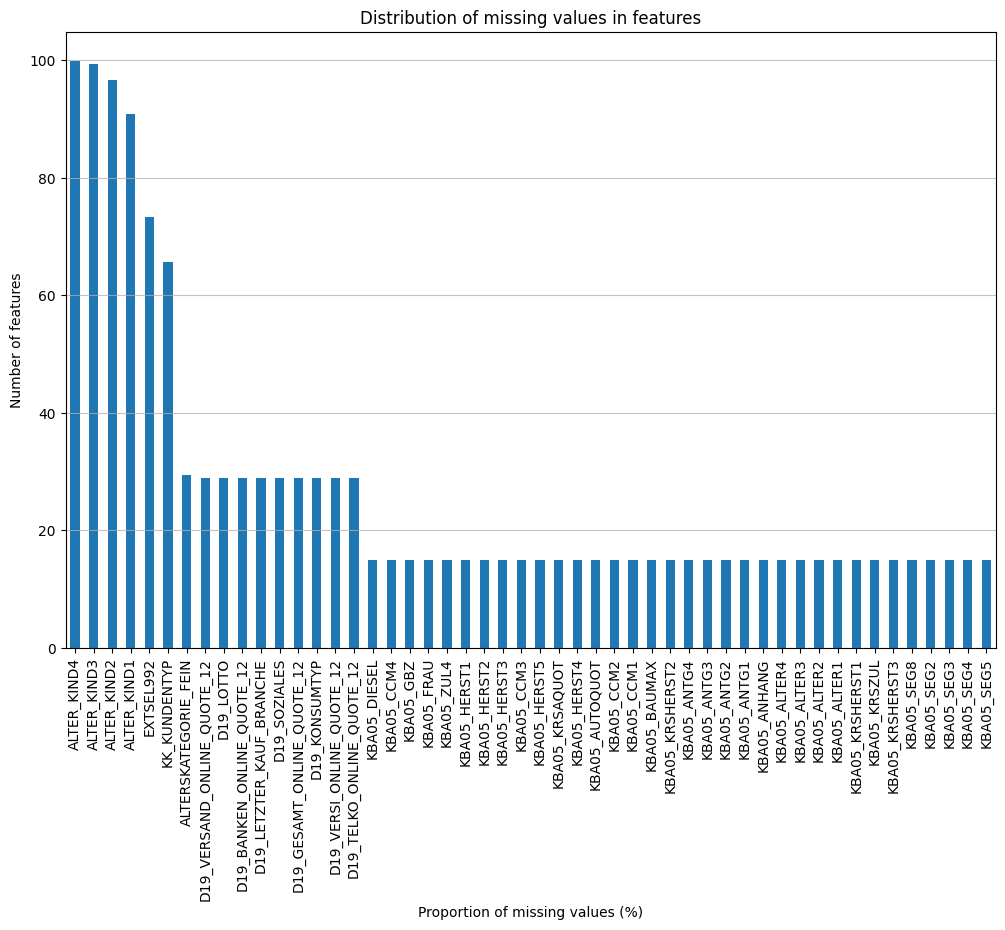

In [11]:
plot_missing_value_histogram_col(azdias)

In [12]:
missing_percent = azdias.isnull().mean() * 100
missing_percent_sorted = missing_percent.sort_values(ascending=False)

In [13]:
drop_null_cols = list(missing_percent_sorted[missing_percent_sorted > 20].index)
len(drop_null_cols)

16

In [14]:
drop_null_cols

['ALTER_KIND4',
 'ALTER_KIND3',
 'ALTER_KIND2',
 'ALTER_KIND1',
 'EXTSEL992',
 'KK_KUNDENTYP',
 'ALTERSKATEGORIE_FEIN',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_LOTTO',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_SOZIALES',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_VERSI_ONLINE_QUOTE_12',
 'D19_TELKO_ONLINE_QUOTE_12']

In [15]:
# Dropping columns with a high percentage of missing values
threshold = 0.2  # Threshold for missing values
azdias = azdias[azdias.columns[azdias.isnull().mean() < threshold]]

In [16]:
azdias.shape

(891221, 350)

Clean row-wise missing data

In [17]:
azdias_percent_missing_row = azdias.isnull().mean(axis=1)

In [18]:
azdias_percent_missing_row 

0         0.674286
1         0.000000
2         0.000000
3         0.005714
4         0.000000
            ...   
891216    0.017143
891217    0.000000
891218    0.005714
891219    0.000000
891220    0.000000
Length: 891221, dtype: float64

In [19]:
def plot_missing_value_histogram_row(df):
    """
    Plot histogram of missing values to find a threshold for dropping columns.
    
    Parameters:
    df (DataFrame): Input DataFrame
    
    Returns:
    None
    """
    # Calculate the percentage of missing values for each column and sort them
    missing_percent = df.isnull().mean(axis=1) * 100
    missing_percent_sorted = missing_percent.sort_values(ascending=False)
    
    # Create a DataFrame for the missing values
    missing_percent_df = pd.DataFrame({
        'column_name': missing_percent_sorted.index,
        'percent_missing': missing_percent_sorted.values
    })
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(missing_percent_sorted, bins=40, edgecolor='k', alpha=0.7)
    plt.xlabel('Proportion of missing values (%)')
    plt.ylabel('Number of rows')
    plt.title('Distribution of missing values in features')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

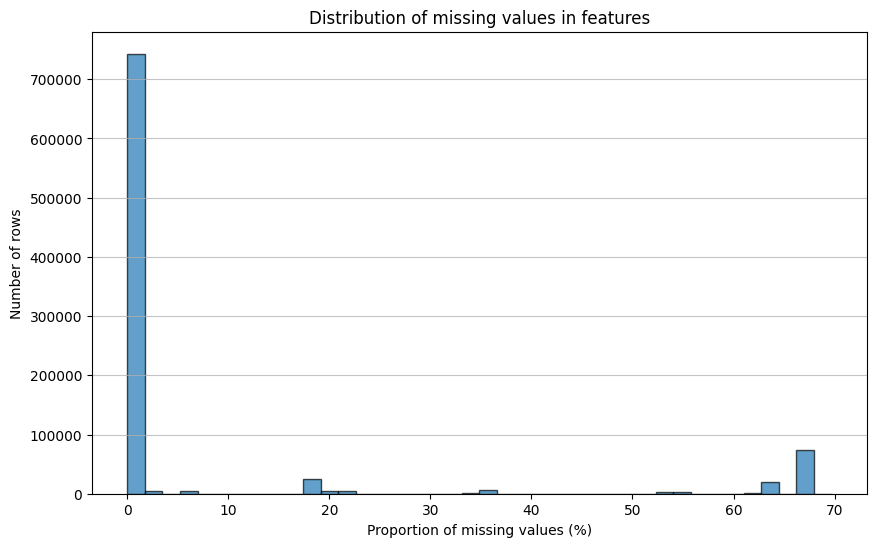

In [20]:
plot_missing_value_histogram_row(azdias)

In [21]:
azdias = azdias[azdias_percent_missing_row <= 0.1]

In [22]:
azdias.shape

(751331, 350)

Re-encode categorical and mixed features

In [23]:
azdias_object_cols = azdias.select_dtypes(['object'])

In [24]:
for col in azdias_object_cols:
    print(col, ': ', len(azdias[col].unique()), 'values, ', azdias[col].unique())

CAMEO_DEU_2015 :  46 values,  ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '7A' '5D' '9E' '5C'
 '9B' '1B' '8B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C' 'XX']
CAMEO_DEUG_2015 :  20 values,  [8.0 4.0 2.0 6.0 1.0 9.0 7.0 5.0 3.0 nan '3' '7' '2' '4' '8' '9' '6' '5'
 '1' 'X']
CAMEO_INTL_2015 :  44 values,  [51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 41.0 34.0 55.0 33.0 25.0 nan
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '24' '41' '12' '54' '51' '44' '35'
 '23' '25' '14' '34' '52' '55' '31' '32' '22' '15' '13' '43' '45' '33'
 'XX']
EINGEFUEGT_AM :  2825 values,  ['1992-02-10 00:00:00' '1992-02-12 00:00:00' '1997-04-21 00:00:00' ...
 '1994-10-24 00:00:00' '2000-03-09 00:00:00' '2005-03-19 00:00:00']
OST_WEST_KZ :  2 values,  ['W' 'O']


In [25]:
azdias.drop(['CAMEO_DEU_2015', 'EINGEFUEGT_AM'], axis = 1, inplace=True)

In [26]:
# Treat 'X' and 'XX' as NaN values and convert to float
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].replace('X', np.nan).astype(float)
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].replace('XX', np.nan).astype(float)

In [27]:
#convert W and O to boolean values
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].map({'W': 0, 'O': 1})

In [28]:
azdias["ANREDE_KZ"] = azdias["ANREDE_KZ"].replace({1: 0, 2: 1})

Descriptive statistics and impute missing values

In [29]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,7.513310e+05,751331.000000,751331.000000,751331.000000,751331.000000,747987.000000,751331.000000,751331.000000,751331.000000,751331.000000,...,744046.000000,749120.000000,749120.000000,749120.000000,719848.000000,751331.000000,751331.000000,751331.000000,751331.000000,751331.000000
mean,6.367752e+05,-0.293083,4.439994,10.819096,8.508822,0.041128,0.144063,1.728602,7.791223,0.004139,...,2.420408,6.043456,7.558340,5.941136,4.058655,7.962734,4.053932,3.400596,0.521717,2.822422
std,2.580028e+05,1.234016,3.649624,7.635330,15.663400,0.319720,0.485299,1.162490,14.399861,0.068283,...,1.163156,2.855643,3.257749,2.785767,1.894214,1.890432,1.891965,1.404571,0.499528,1.081793
min,1.916530e+05,-1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
25%,4.132270e+05,-1.000000,1.000000,0.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,2.000000,4.000000,6.000000,4.000000,3.000000,8.000000,3.000000,3.000000,0.000000,2.000000
50%,6.349700e+05,-1.000000,3.000000,13.000000,4.000000,0.000000,0.000000,1.000000,4.000000,0.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,1.000000,3.000000
75%,8.617140e+05,1.000000,9.000000,17.000000,10.000000,0.000000,0.000000,2.000000,9.000000,0.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,1.000000,4.000000
max,1.082872e+06,3.000000,9.000000,21.000000,536.000000,20.000000,11.000000,45.000000,449.000000,4.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,9.000000


In [30]:
imputer = SimpleImputer(strategy="most_frequent")

azdias_cleaned = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns)

In [31]:
azdias_cleaned.shape

(751331, 348)

Removing highly correlated features

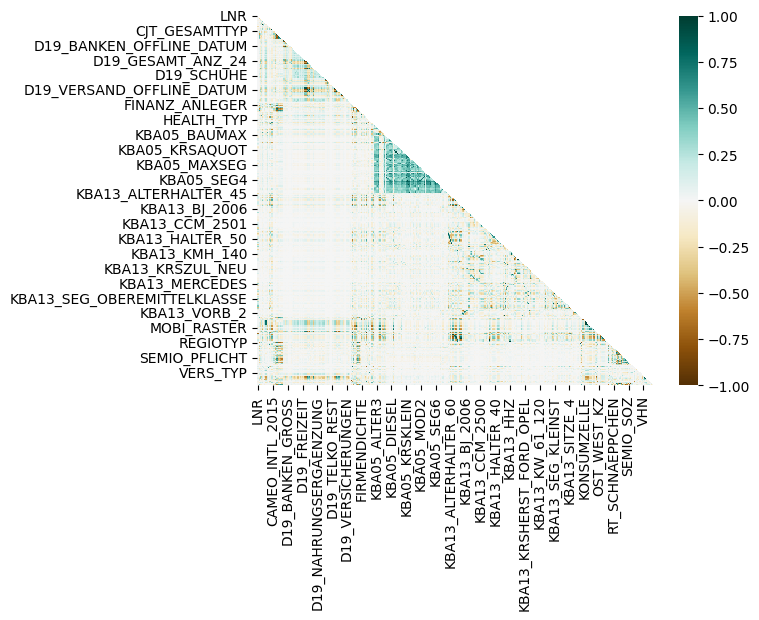

In [32]:
corr_mat = azdias_cleaned.corr()
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
heatmap = sns.heatmap(corr_mat, vmin=-1, vmax=1, mask=mask, cmap='BrBG')

In [33]:
def remove_correlated_columns(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    return drops

In [34]:
col_to_remove = remove_correlated_columns(azdias_cleaned, 0.8)

In [35]:
len(col_to_remove)

62

In [36]:
azdias_cleaned.drop(columns=col_to_remove, inplace=True)

One hot encoding

In [37]:
# categorical_columns = azdias.select_dtypes(include=['object']).columns

# # Apply one-hot encoding using pd.get_dummies
# azdias_cleaned = pd.get_dummies(azdias, columns=categorical_columns, drop_first=True)


### Cleaning function for CUSTOMERS dataset

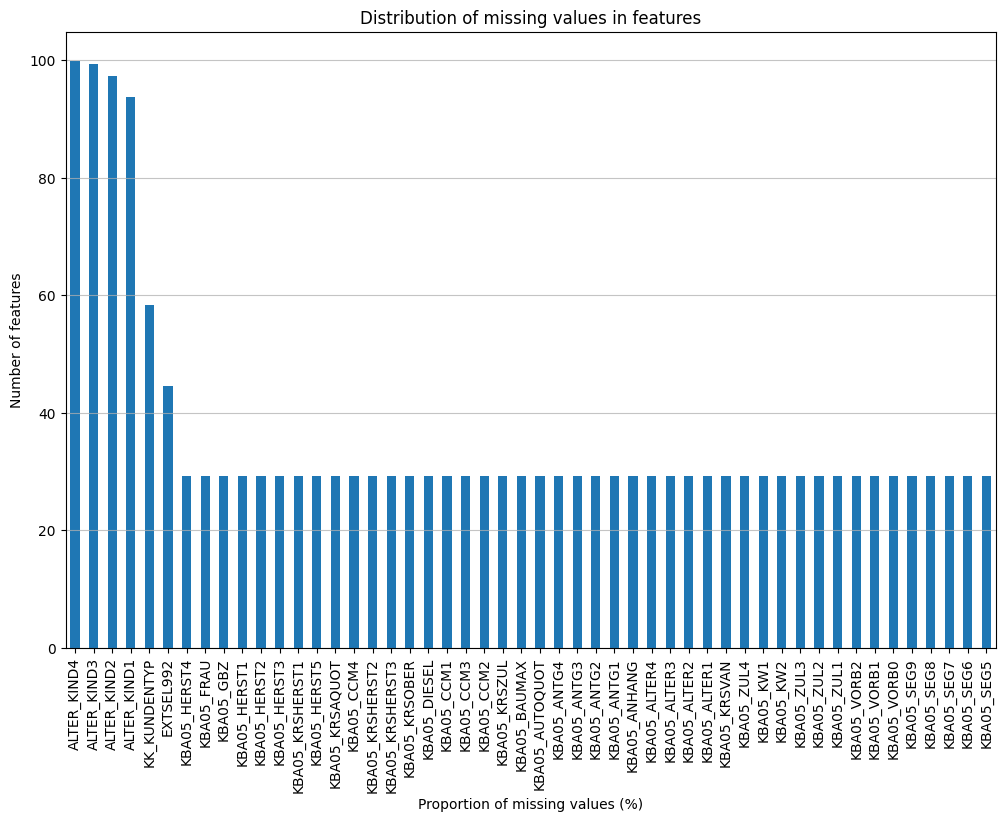

In [38]:
plot_missing_value_histogram_col(customers)

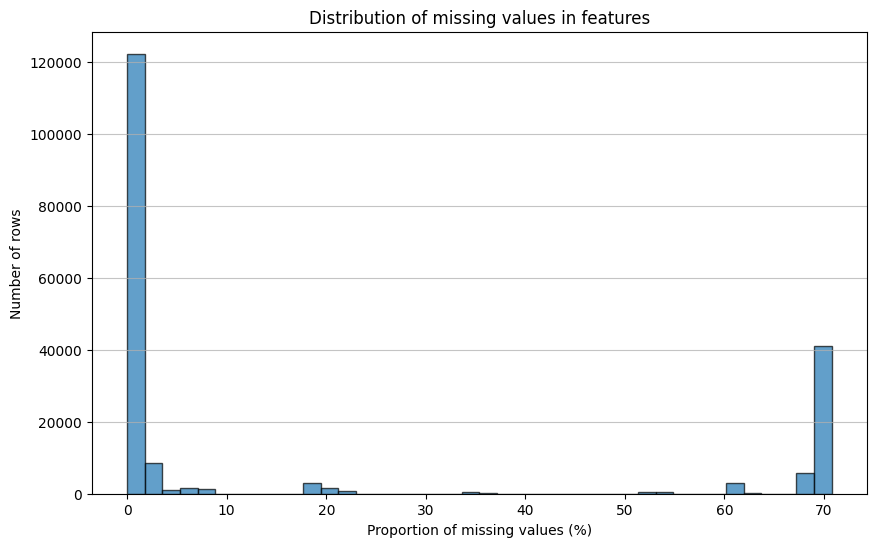

In [39]:
plot_missing_value_histogram_row(customers)

In [40]:
customers = customers.drop(drop_null_cols, axis=1)

In [41]:
customers.shape

(191652, 350)

In [42]:
def clean_data(df, threshold_row):
    
    df = df
    
    # Step 1: Calculate and plot the percentage of missing values for each column
    #df_missing_percent = df.isnull().mean().sort_values(ascending=False) * 100

    # Step 2: Determine threshold for dropping columns with high missing values
    #df = df[df.columns[df.isnull().mean() < threshold_column]]

    # Step 3: Drop rows with more than 10% missing values
    df = df[df.isnull().mean(axis = 1) <= threshold_row]

    # Drop columns
    df.drop(['CAMEO_DEU_2015', 'EINGEFUEGT_AM'], axis = 1, inplace=True)
    

    # Step 5: Treat 'X' and 'XX' as NaN values and convert to float
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan).astype(float)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace('XX', np.nan).astype(float)

    # Convert 'OST_WEST_KZ' to boolean values
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 0, 'O': 1})

    # Convert 'ANREDE_KZ' to binary
    df["ANREDE_KZ"] = df["ANREDE_KZ"].replace({1: 0, 2: 1})

    # Step 6: Impute missing values using the most frequent strategy
    imputer = SimpleImputer(strategy="most_frequent")
    df_cleaned = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)


    return df_cleaned

In [43]:
customers_cleaned = clean_data(customers, 0.1)

C:\Users\TienTTT13\AppData\Local\Temp\ipykernel_25172\3512012862.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['CAMEO_DEU_2015', 'EINGEFUEGT_AM'], axis = 1, inplace=True)
C:\Users\TienTTT13\AppData\Local\Temp\ipykernel_25172\3512012862.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan).astype(float)
C:\Users\TienTTT13\AppData\Local\Temp\ipykernel_25172\3512012862.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [ ]:
customers_cleaned.shape

In [44]:
customers_cleaned.drop(columns=col_to_remove, inplace=True)

In [45]:
customers_cleaned.shape

(135144, 286)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [46]:
scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_cleaned), columns=azdias_cleaned.columns)

In [47]:
azdias_scaled.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB
count,7.513310e+05,7.513310e+05,7.513310e+05,7.513310e+05,7.513310e+05,7.513310e+05,7.513310e+05,7.513310e+05,7.513310e+05,7.513310e+05,...,7.513310e+05,7.513310e+05,7.513310e+05,7.513310e+05,7.513310e+05,7.513310e+05,7.513310e+05,7.513310e+05,7.513310e+05,7.513310e+05
mean,-6.941526e-18,1.709847e-17,1.780019e-16,5.031188e-18,-2.621514e-17,2.080566e-17,5.601452e-17,9.356874e-17,-3.291078e-18,7.490985e-17,...,-5.295987e-17,-1.270848e-16,-6.082820e-17,-7.617710e-17,3.183267e-17,-6.676727e-17,-1.359556e-16,-1.785315e-16,1.010872e-16,-1.463206e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.725262e+00,-5.728594e-01,-9.425618e-01,-1.416979e+00,-5.432300e-01,-1.283455e-01,-2.968541e-01,-1.486983e+00,-6.062012e-02,-2.200032e+00,...,-5.436202e-01,-3.339163e+00,-3.871492e-01,-2.086219e+00,-1.767840e+00,-2.185315e+00,-3.683146e+00,-2.142711e+00,-1.709132e+00,-1.684632e+00
25%,-8.664570e-01,-5.728594e-01,-9.425618e-01,-1.416979e+00,-4.155437e-01,-1.283455e-01,-2.968541e-01,-6.267597e-01,-6.062012e-02,-1.903869e-01,...,-5.436202e-01,-5.694642e-01,-3.871492e-01,-3.594536e-01,-7.186973e-01,-6.017548e-01,1.971289e-02,-5.570573e-01,-2.852088e-01,-7.602401e-01
50%,-6.996822e-03,-5.728594e-01,-3.945598e-01,2.856334e-01,-2.878574e-01,-1.283455e-01,-2.968541e-01,-6.267597e-01,-6.062012e-02,-1.903869e-01,...,-4.255844e-01,8.153851e-01,-3.871492e-01,-3.594536e-01,-1.926909e-02,-7.390135e-02,5.486928e-01,-5.570573e-01,-2.852088e-01,1.641518e-01
75%,8.718469e-01,1.047866e+00,1.249446e+00,8.095142e-01,9.520147e-02,-1.283455e-01,-2.968541e-01,2.334631e-01,-6.062012e-02,8.144359e-01,...,4.655883e-02,8.153851e-01,-3.871492e-01,5.039289e-01,1.029873e+00,9.818055e-01,5.486928e-01,5.000454e-01,4.267528e-01,1.088544e+00
max,1.729040e+00,2.668591e+00,1.249446e+00,1.333395e+00,3.367670e+01,6.256380e+01,2.236959e+01,3.722304e+01,5.851916e+01,5.838549e+00,...,4.767991e+00,8.153851e-01,3.953485e+00,1.367311e+00,1.729301e+00,9.818055e-01,5.486928e-01,2.085699e+00,1.850676e+00,5.710503e+00


PCA on AZDIAS

In [48]:
cov_mat = np.cov(azdias_scaled.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('Eigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 4.63257615e-03 -3.43222807e-02  9.22356745e-02 ...  1.55310521e-03
  -2.96119416e-05  1.79677809e-05]
 [ 7.08403768e-04 -3.38370571e-02 -1.38187470e-02 ...  3.96393475e-02
   1.97650195e-02  1.59033729e-02]
 [-2.60524786e-02  7.17206117e-02  2.38464408e-02 ... -4.60039684e-03
  -1.43063986e-02 -2.44995957e-02]
 ...
 [ 1.08107351e-02 -5.12675841e-02 -9.14029676e-02 ... -1.60306292e-02
   4.48215808e-02 -2.90554777e-02]
 [-1.51188196e-02  1.00929114e-01  1.74893573e-03 ...  8.12599977e-02
  -2.61583153e-02 -2.25868214e-02]
 [-1.32292184e-02 -4.32984586e-02 -1.55031443e-02 ... -1.26201132e-01
  -4.25830017e-02 -8.64460624e-02]]
Eigenvalues 
[20.65054897 19.28423073 13.96843492 11.90920461  8.55171485  7.4250619
  6.0772902   4.99489443  4.5957359   3.80591086  3.576775    3.26271684
  3.06574204  2.94157535  2.88800351  2.8165756   2.61467208  2.54997519
  2.43795062  2.30707746  2.24303621  2.15103516  2.03601462  1.95621967
  1.89430231  1.87544103  1.84271097  1.772896

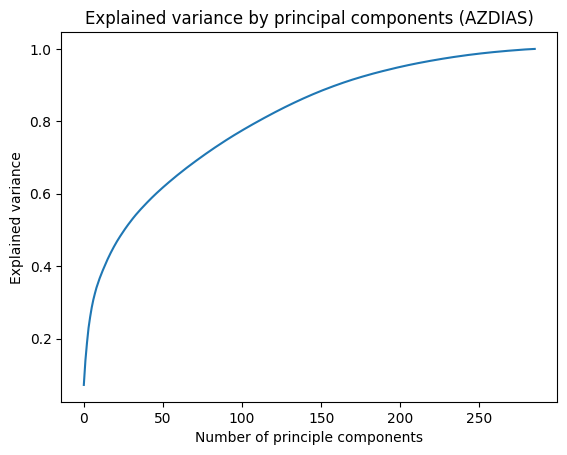

In [49]:
# plot explained variance on AZDIAS

pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained variance by principal components (AZDIAS)')
plt.xlabel('Number of principle components')
plt.ylabel('Explained variance')

plt.show()

In [50]:
def reduce_dimension(df, n):
    
    pca = PCA(n_components=n)
    
    reduced_df = pca.fit_transform(df)
    reduced_df = pd.DataFrame(reduced_df)
    
    print('The variance in the data explained by the principal components after employing PCA is equal to ' + str(pca.explained_variance_ratio_.sum())) 
    
    return reduced_df

In [51]:
reduced_azdias = reduce_dimension(azdias_scaled, 150)

The variance in the data explained by the principal components after employing PCA is equal to 0.8823951943192604


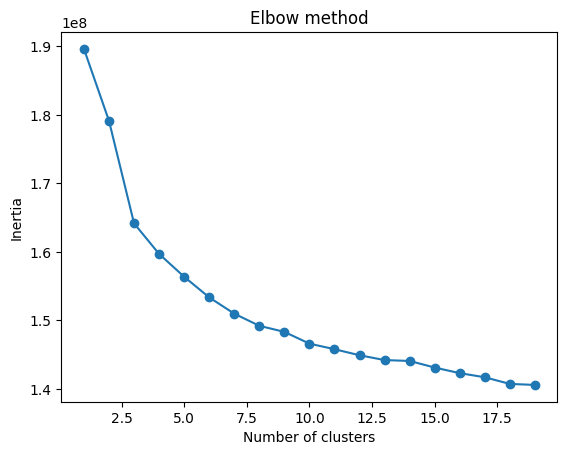

In [52]:
inertias = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(reduced_azdias)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,20), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [53]:
selected_cluster = 10

kmeans = KMeans(n_clusters=selected_cluster)

In [54]:
reduced_azdias = reduced_azdias.astype(np.float32)


In [55]:
azdias_clusters = kmeans.fit_predict(reduced_azdias)

In [56]:
azdias_clusters

array([1, 1, 8, ..., 2, 4, 8])

Customers dimension reduction pipeline

In [57]:
# Assuming azdias_scaled and customers_scaled are already defined as scaled DataFrames
# Replace with your actual scaled dataframes

# Define a function to create the pipeline
def create_pipeline(n_components=150, n_clusters=10):
    """
    Create a pipeline for preprocessing and KMeans clustering.
    
    Parameters:
    n_components (int): Number of principal components for PCA (default is 150)
    n_clusters (int): Number of clusters for KMeans (default is 12)
    
    Returns:
    pipeline (Pipeline object): Pipeline containing preprocessing and clustering steps
    """
    # Define steps in the pipeline
    steps = [
        ('scaler', StandardScaler()),  # Step 1: StandardScaler for normalization
        ('pca', PCA(n_components=n_components)),  # Step 2: PCA for dimensionality reduction
        ('kmeans', KMeans(n_clusters=n_clusters))  # Step 3: KMeans for clustering
    ]
    
    # Create the pipeline
    pipeline = Pipeline(steps)
    
    return pipeline

# Create pipelines for AZDIAS and CUSTOMERS datasets
customers_pipeline = create_pipeline()

# Fit and transform data using the pipelines
customers_clusters = customers_pipeline.fit_predict(customers_cleaned)




In [58]:
customers_clusters

array([3, 6, 3, ..., 1, 0, 3])

In [59]:
cluster_info = pd.DataFrame([])

cluster_info["Population"] = pd.Series(azdias_clusters).value_counts().sort_index()
cluster_info["Customer"] = pd.Series(customers_clusters).value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)

In [60]:
cluster_info

,Cluster,Population,Customer
0,0,80756,13676
1,1,96860,24892
2,2,77104,15610
3,3,74151,16981
4,4,80335,11162
5,5,99270,898
6,6,14043,15009
7,7,54499,11836
8,8,111593,13023
9,9,62720,12057


In [61]:
cluster_info['%General population'] = (cluster_info['Population'] / (cluster_info['Population'].sum()) * 100).round(2)
cluster_info['%Customer base'] = (cluster_info['Customer'] / (cluster_info['Customer'].sum()) * 100).round(2)

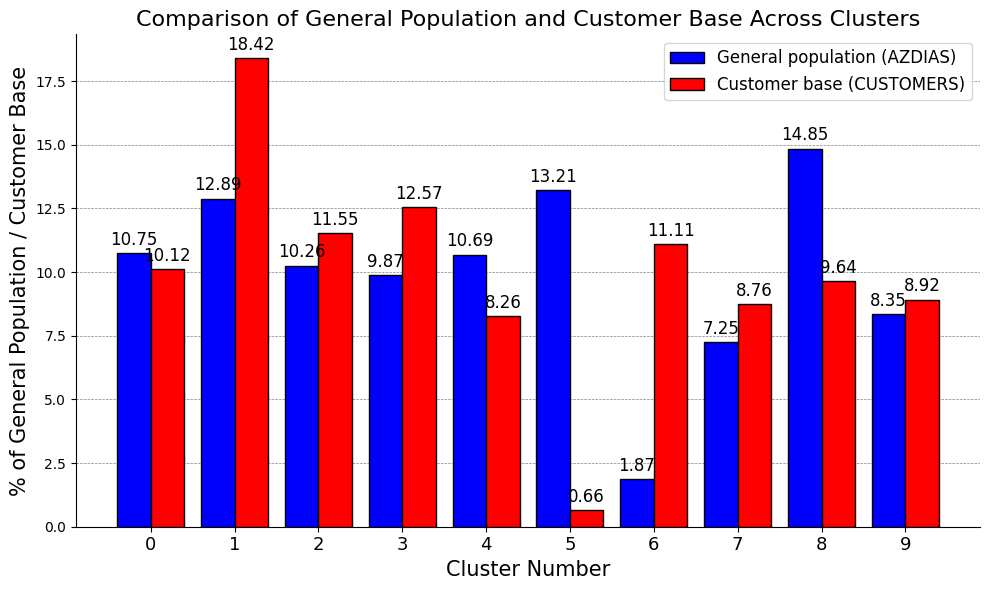

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Define the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width and positions
width = 0.4  # width of the bars
x = np.arange(len(cluster_info['Cluster']))  # the label locations

# Plotting the bars for each data set side by side
rects1 = ax.bar(x - width/2, cluster_info['%General population'], width, label='General population (AZDIAS)', color='blue', edgecolor='black')
rects2 = ax.bar(x + width/2, cluster_info['%Customer base'], width, label='Customer base (CUSTOMERS)', color='red', edgecolor='black')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Cluster Number', fontsize=15)
ax.set_ylabel('% of General Population / Customer Base', fontsize=15)
ax.set_title('Comparison of General Population and Customer Base Across Clusters', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(cluster_info['Cluster'], fontsize=13)
ax.legend(fontsize=12)

# Function to add labels on the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12)

autolabel(rects1)
autolabel(rects2)

# Improve the layout and aesthetics
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, which='major', axis='y', linestyle='--', linewidth='0.5', color='grey')
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [63]:
mailout_train = pd.read_csv(r'C:\Users\TienTTT13\Downloads\Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory=True)

C:\Users\TienTTT13\AppData\Local\Temp\ipykernel_25172\3253641172.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv(r'C:\Users\TienTTT13\Downloads\Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory=True)


In [64]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [65]:
mailout_train.shape

(42962, 367)

RESPONSE
0    42430
1      532
Name: count, dtype: int64


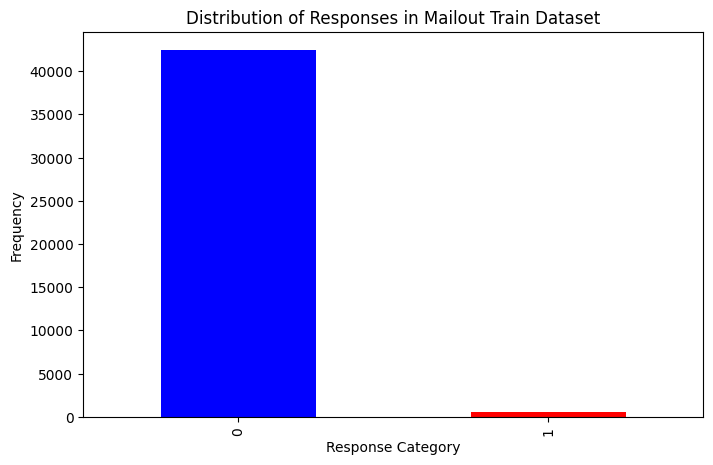

In [66]:
#before cleaning mailout_train dataset

response_counts = mailout_train.RESPONSE.value_counts()
print(response_counts)
response_counts.plot(kind='bar',color=['blue', 'red'], figsize=(8,5))
plt.title('Distribution of Responses in Mailout Train Dataset')
plt.xlabel('Response Category')
plt.ylabel('Frequency')
plt.show()

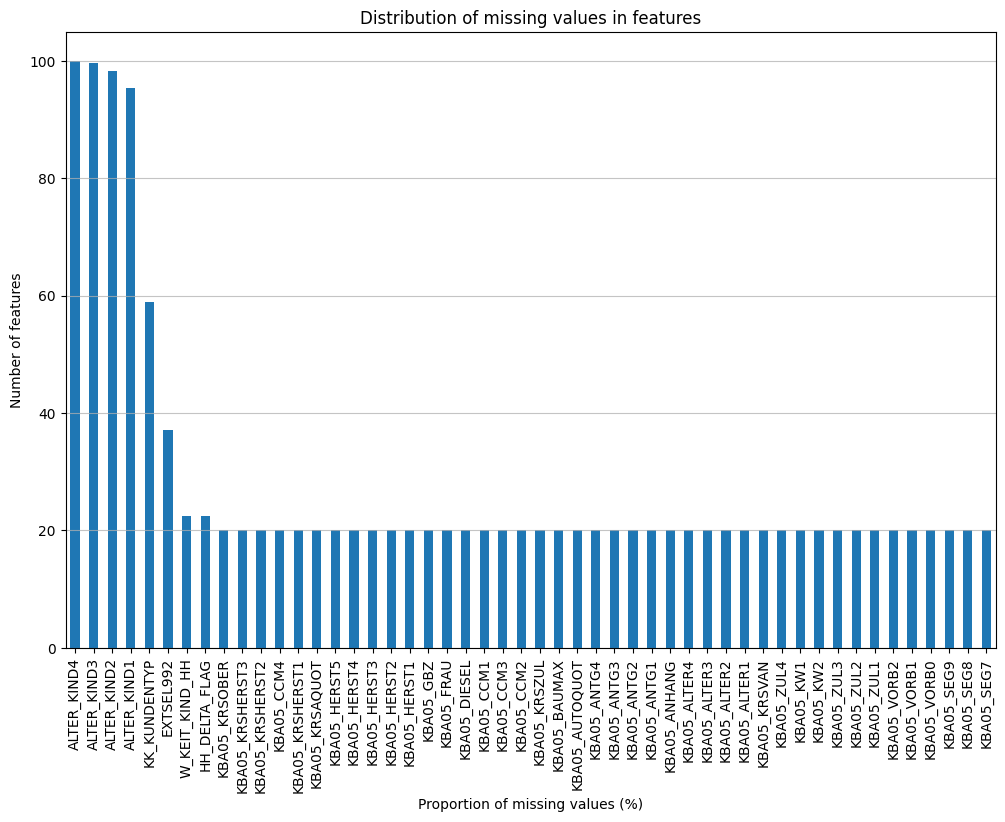

In [67]:
plot_missing_value_histogram_col(mailout_train)

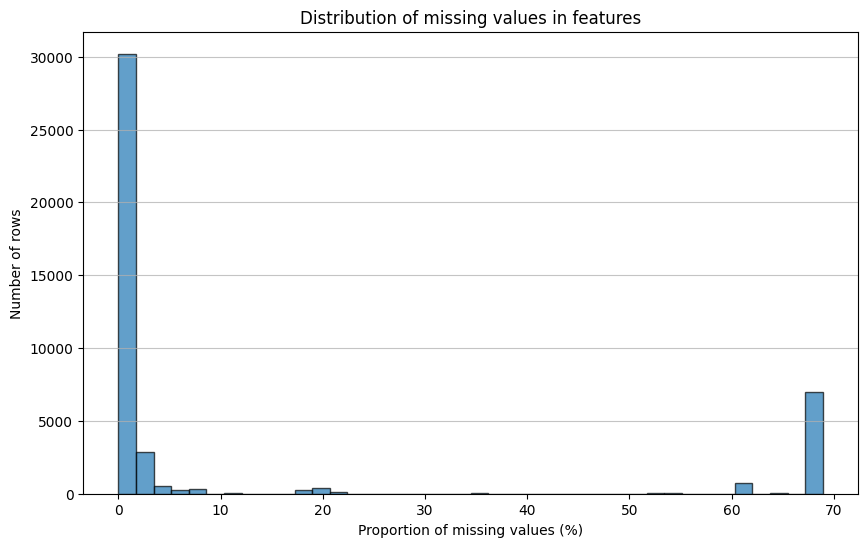

In [68]:
plot_missing_value_histogram_row(mailout_train)

In [69]:
mailout_train_cleaned = clean_data(mailout_train, 0.1)

C:\Users\TienTTT13\AppData\Local\Temp\ipykernel_25172\3512012862.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['CAMEO_DEU_2015', 'EINGEFUEGT_AM'], axis = 1, inplace=True)
C:\Users\TienTTT13\AppData\Local\Temp\ipykernel_25172\3512012862.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan).astype(float)
C:\Users\TienTTT13\AppData\Local\Temp\ipykernel_25172\3512012862.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [70]:
mailout_train_cleaned = mailout_train_cleaned.drop(drop_null_cols, axis=1)

In [71]:
mailout_train_cleaned.drop(columns=col_to_remove, inplace=True)

In [72]:
mailout_train_cleaned.shape

(34192, 287)

RESPONSE
0    33768
1      424
Name: count, dtype: int64


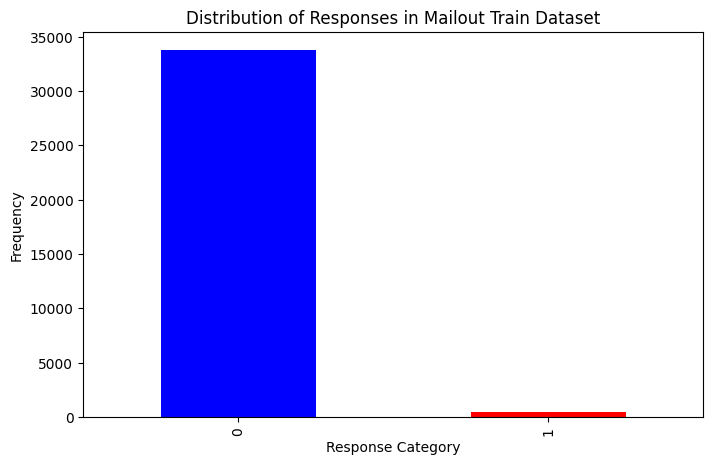

In [73]:
#after cleaning mailout_train dataset

response_counts = mailout_train_cleaned.RESPONSE.value_counts()
print(response_counts)
response_counts.plot(kind='bar',color=['blue', 'red'], figsize=(8,5))
plt.title('Distribution of Responses in Mailout Train Dataset')
plt.xlabel('Response Category')
plt.ylabel('Frequency')
plt.show()

In [74]:
# import pycaret

In [75]:
# # setting up pycaret with normalization and balancing
# s = setup(mailout_train_cleaned, target = 'RESPONSE',
#           normalize = True,
#           fix_imbalance = True)

In [76]:
# # run models to compare
# best = compare_models(sort = 'auc')

In [77]:
X = mailout_train_cleaned.drop(['RESPONSE'], axis=1)
y = mailout_train_cleaned['RESPONSE'].astype(int)

In [78]:
mailout_train_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [79]:
# mailout_train_normalize = pd.DataFrame(scaler.fit_transform(mailout_train_cleaned), columns=mailout_train_cleaned.columns)

In [80]:
X_mailout_train, X_mailout_test, y_mailout_train, y_mailout_test = train_test_split(
                                                                                    mailout_train_normalized, y, stratify=y, test_size=0.2, random_state=42
                                                                                    )

In [81]:
# model = model.fit(X_mailout_train, y_mailout_train)

# y_prob = model.predict_proba(X_test)[:,1]
# y_prob

In [82]:
# from sklearn.metrics import classification_report
# model_rf = RandomForestClassifier(random_state=42)
# model_rf.fit(X_mailout_train, y_mailout_train)
# y_rf_pred = model_rf.predict(X_mailout_test)
# report_rf = classification_report(y_mailout_test, y_rf_pred)
# print(report_rf)

In [83]:
def train_and_predict(model, X_train, y_train, X_test, y_test):
    # Ensure labels are integer if they're not already
    # y_train = y_train.astype(int)
    # y_test = y_test.astype(int)
    
    # Fit the model on training data
    model = model.fit(X_train, y_train)

    # Predict probabilities for the positive class
    y_prob = model.predict(X_test)

    # Convert probabilities to binary class labels based on a threshold
    threshold = 0.5
    y_pred = (y_prob >= threshold).astype(int)

    # Calculate metrics
    roc_score = roc_auc_score(y_test, y_prob)  # Use probabilities for ROC AUC
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f_1 = f1_score(y_test, y_pred)

    return model, accuracy, roc_score, precision, recall, f_1


In [84]:
models = {'RandomForestClassifier': RandomForestClassifier(class_weight='balanced'), 
          'LogisticRegression': LogisticRegression(),
          'DecisionTreeClassifier': DecisionTreeClassifier(),
          'AdaBoostClassifier': AdaBoostClassifier(algorithm='SAMME'), 
          'GradientBoostingClassifier': GradientBoostingClassifier(),
          'XGBClassifier': xgb.XGBClassifier()
         }

In [85]:
results = {"Model":[],
          "Accuracy":[],
          "AUC":[],
          "Precision":[],
          "Recall":[],
          "F1":[]}

for name, model in models.items():
    try:
        model, accuracy, roc_score, precision, recall, f_1 = train_and_predict(model, X_mailout_train, y_mailout_train, X_mailout_test, y_mailout_test)
        results["Model"].append(name)
        results["Accuracy"].append(accuracy)
        results["AUC"].append(roc_score)
        results["Precision"].append(precision)
        results["Recall"].append(recall)
        results["F1"].append(f_1)
    except Exception as e:
        print(f"Error processing model {name}: {e}")



c:\Users\TienTTT13\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\TienTTT13\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\TienTTT13\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\T

In [86]:
results_df = pd.DataFrame(results)
print(results_df)

# Optionally, you can sort by a specific metric
sorted_results = results_df.sort_values(by='Accuracy', ascending=False)
print(sorted_results)

                        Model  Accuracy       AUC  Precision    Recall  \
0      RandomForestClassifier  0.987571  0.500000      0.000  0.000000   
1          LogisticRegression  0.987571  0.500000      0.000  0.000000   
2      DecisionTreeClassifier  0.969879  0.502659      0.016  0.023529   
3          AdaBoostClassifier  0.987571  0.500000      0.000  0.000000   
4  GradientBoostingClassifier  0.986255  0.499334      0.000  0.000000   
5               XGBClassifier  0.987571  0.500000      0.000  0.000000   

         F1  
0  0.000000  
1  0.000000  
2  0.019048  
3  0.000000  
4  0.000000  
5  0.000000  
                        Model  Accuracy       AUC  Precision    Recall  \
0      RandomForestClassifier  0.987571  0.500000      0.000  0.000000   
1          LogisticRegression  0.987571  0.500000      0.000  0.000000   
3          AdaBoostClassifier  0.987571  0.500000      0.000  0.000000   
5               XGBClassifier  0.987571  0.500000      0.000  0.000000   
4  GradientBo

In [87]:
results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

,Model,Accuracy,AUC,Precision,Recall,F1
0,RandomForestClassifier,0.987571,0.5,0.0,0.0,0.0
1,LogisticRegression,0.987571,0.5,0.0,0.0,0.0
2,DecisionTreeClassifier,0.969879,0.502659,0.016,0.023529,0.019048
3,AdaBoostClassifier,0.987571,0.5,0.0,0.0,0.0
4,GradientBoostingClassifier,0.986255,0.499334,0.0,0.0,0.0
5,XGBClassifier,0.987571,0.5,0.0,0.0,0.0


In [88]:
param_grid = {
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [None, 10, 20, 30], 
    "min_samples_split": [2, 5, 10]  
}

randomforest_grid = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                                 param_grid=param_grid, 
                                 scoring="roc_auc", 
                                 cv=5, n_jobs=-1, verbose=2)




In [89]:
y_mailout_train = y_mailout_train.astype(int)


In [90]:
randomforest_grid.fit(X_mailout_train, y_mailout_train)

best_randomforest = randomforest_grid.best_estimator_

print("Best Score: ", randomforest_grid.best_score_)
print("Best Params: ", randomforest_grid.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Score:  0.55142754686596
Best Params:  {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}


In [91]:
preds_randomforest = best_randomforest.predict_proba(X_mailout_test)[:,1]

print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_mailout_test, preds_randomforest)))


ROC score on validation data: 0.4981


In [92]:
def plot_feature_importances(model, model_name, feature_names, num_features=10):
    """
    Plots top n feature importances for the given model
    """

    
    feature_importance_values= np.zeros((len(model.feature_importances_)))
    
    feature_importance_values += model.feature_importances_

    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # sort based on importance
    feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

    # normalize the feature importances to add up to one
    feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
    feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])
    
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    
    ax.barh(list(reversed(list(feature_importances.index[:num_features]))), 
                feature_importances['normalized_importance'][:num_features], 
                align = 'center')

    # Set ticks and labels
    ax.set_yticks(list(reversed(list(feature_importances.index[:num_features]))))
    ax.set_yticklabels(feature_importances['feature'][:num_features])
    ax.set_xlabel('Normalized Importance')
    ax.set_title(f'Feature Importances ({model_name})') 

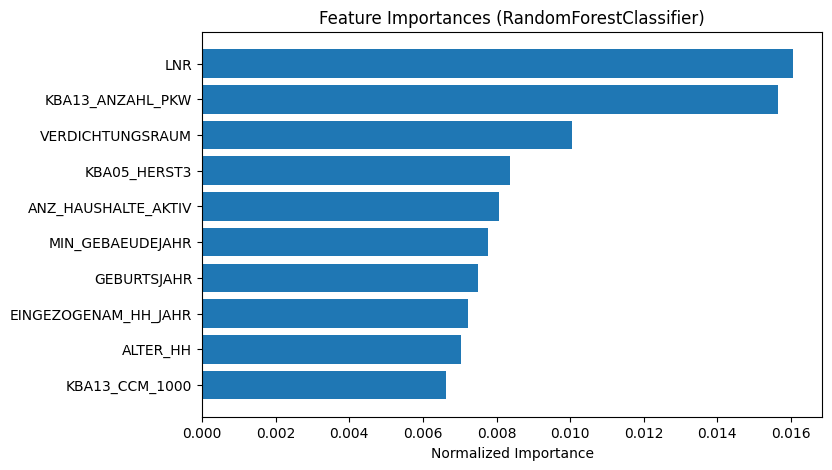

In [93]:
plot_feature_importances(model=best_randomforest, model_name="RandomForestClassifier", feature_names=mailout_train_normalized.columns)

In [94]:
# # Save to file in the current working directory
# pkl_filename = "best_gradient_boosting.pkl"  
# with open(pkl_filename, 'wb') as file:  
#     pickle.dump(best_clf, file)

In [95]:
mailout_test = pd.read_csv('C:/Users/TienTTT13/Downloads/Udacity_MAILOUT_052018_TEST.csv', sep = ";")

C:\Users\TienTTT13\AppData\Local\Temp\ipykernel_25172\4231862192.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('C:/Users/TienTTT13/Downloads/Udacity_MAILOUT_052018_TEST.csv', sep = ";")


In [96]:
mailout_test.shape

(42833, 366)

Clean data

In [97]:
mailout_test_LNR = mailout_test["LNR"]

In [98]:
mailout_test_cleaned = clean_data(mailout_test, 0.1)

C:\Users\TienTTT13\AppData\Local\Temp\ipykernel_25172\3512012862.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['CAMEO_DEU_2015', 'EINGEFUEGT_AM'], axis = 1, inplace=True)
C:\Users\TienTTT13\AppData\Local\Temp\ipykernel_25172\3512012862.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan).astype(float)
C:\Users\TienTTT13\AppData\Local\Temp\ipykernel_25172\3512012862.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [99]:
mailout_test_cleaned = mailout_test_cleaned.drop(drop_null_cols, axis=1)

In [100]:
mailout_test_cleaned.drop(columns=col_to_remove, inplace=True)

In [101]:
mailout_test_cleaned.shape

(34160, 286)

In [102]:
mailout_test_normalized = pd.DataFrame(scaler.fit_transform(mailout_test_cleaned), columns=X.columns)

In [103]:
pred_test_rf = best_randomforest.predict_proba(mailout_test_normalized)[:,1]

In [104]:
pred_test_rf

array([0.03328172, 0.0105469 , 0.04476854, ..., 0.005     , 0.03014076,
       0.0235119 ])

In [105]:
test_rf_result = pd.DataFrame(data=pred_test_rf)
test_rf_result.rename(columns={0: "RESPONSE"}, inplace=True)

In [106]:
test_rf_result

,RESPONSE
0,0.033282
1,0.010547
2,0.044769
3,0.012000
4,0.042579
...,...
34155,0.013496
34156,0.033912
34157,0.005000
34158,0.030141
